# Detecting distribution changes in data streams

Many real world problems involve time component, usually to monitor some phenomenon that can potentially change over time. This change could be for example a burst in network traffic, some abnormal video survelliance activity or some anomalous change in user's behaviour.

One common concept of the before mentioned scenarios is the concept of **data stream**, which is a modality in which data points are observed sequentially in time, rather than all at once.

In this data stream setting, we would like to have a learning model to learn the dynamics of the current stream, and somehow be able to signal whether or not there's a change in the data generating distribution.

**Example**

Suppose there is a random process that at each time step generates a value from a probability distribution $\mathcal{N}(\mu_1, \sigma_1)$.

Suppose we are observing one measurement $x_i$ at a time, thus, $x_1,x_2,....,x_t$ a set of measurements up to a time step $t$.

Now, if there random process whose values we are observing changes its distribution to $\mathcal{N}(\mu_2, \sigma_2)$, the values $x_{t+1},...,x_{t'}$ will follow the new distribution.

Thus the task of distribution change detection consists in promptly finding this moment $t$ in which the change of distribution has occurred.

## Approach

In this notebook we will present one possible approach to automatically detect such changes, that is based on martingale testing, defined in "A Martingale Framework for Detecting Changes in Data Streams by Testing Exchangeability".

In a nutshell, this approach keeps a set of points captured online, which are updated as they arrive.

**Building blocks of the algorithm**

- Intuitively, a martingale is a sequence of random variables that remains stable in value with some fluctuations as long as the process is random

- The algorithm operates on a null hypothesis $H_0$ that data sequence if exchangable (i.e. exchangeability property holds).

- A fundamental building block of this martingale for change detection called the strangeness measure which scores how much a data point is different from the other data points in the current set.

- After each new data point is received, an observer outputs a positive martingale value reflecting the strength of evidence found against the null hypothesis of data exchangeability.

- We'll assume that we are working with a cluster model (formed by our current set)

- $\hat{p}$-value function is defined as $\hat{p}(\{x_1,...,x_i\}, \theta_i) = \frac{|\{j:s_j>s_i\}| + \theta_i|\{j:s_j=s_i\}|}{i}$ where $\theta_i \sim U(0, 1)$.

- Randomized power martingale is defined as $M_n^{(\epsilon)} = \prod_{i=1}^n \epsilon\hat{p}_i^{\epsilon - 1}$

-  If points are generated from a source that satisfies exchangeability property (i.e. points are coming from the same distribution), then there's a property that $\hat{p}$-values will be distributed uniformly on $[0, 1]$. However, if this property is violated, then $\hat{p}$-values will no longer be distributed uniformly in $[0, 1]$ (due to strangeness of newer points being likely higher), as a result $M_n^{(\epsilon)}$ will increase, providing more evidence against null hypothesis $H_0$ of sequence exchangeability.

- Finally, we can employ this property of $M_n^{(\epsilon)}$ to aid in our change detection method. The martingale test continues to operate as long as $0 \lt M_n^{(\epsilon)} \lt \lambda$, and the null hypothesis $H_0$ is rejected when $M_n^{(\epsilon)} \geq \lambda$ namely "no change in data stream" hypothesis has a high evidence against it.

- The parameter $\lambda$ indicates a degree of false alarm rate (FAR) we are willing to accept from our detector.

## Imports

In [1]:
import os

import numpy as np
import pandas as pd

from detectors.martingale_tester import MartingaleTest, run_martingale_tester
from utils.cavitation_data import average_signal_columns, get_cavitation_features, load_cavitation_data
from utils.metrics import metrics_in_range
from utils.synthetic_data import generate_synthetic_normal
from utils.visualization import plot_total_df

## Synthetic example

In [12]:
# Define parameters of synthetic data
sizes_synthetic = [600, 500, 1050, 500]
means_synthetic = [0.34, 1.5, 2.9, 1.5]
std_synthetic = 0.8
changes_gt_synthetic = np.cumsum(sizes_synthetic)[:-1]
# Generate synthetic timeseries dataset
data_synthetic = generate_synthetic_normal(
    locs=means_synthetic, 
    sizes=sizes_synthetic, 
    scale=std_synthetic, dims=1
)
data_df_synthetic = pd.DataFrame(data_synthetic)

Changes in stream distribution occurred at:
	600
	1100
	2150


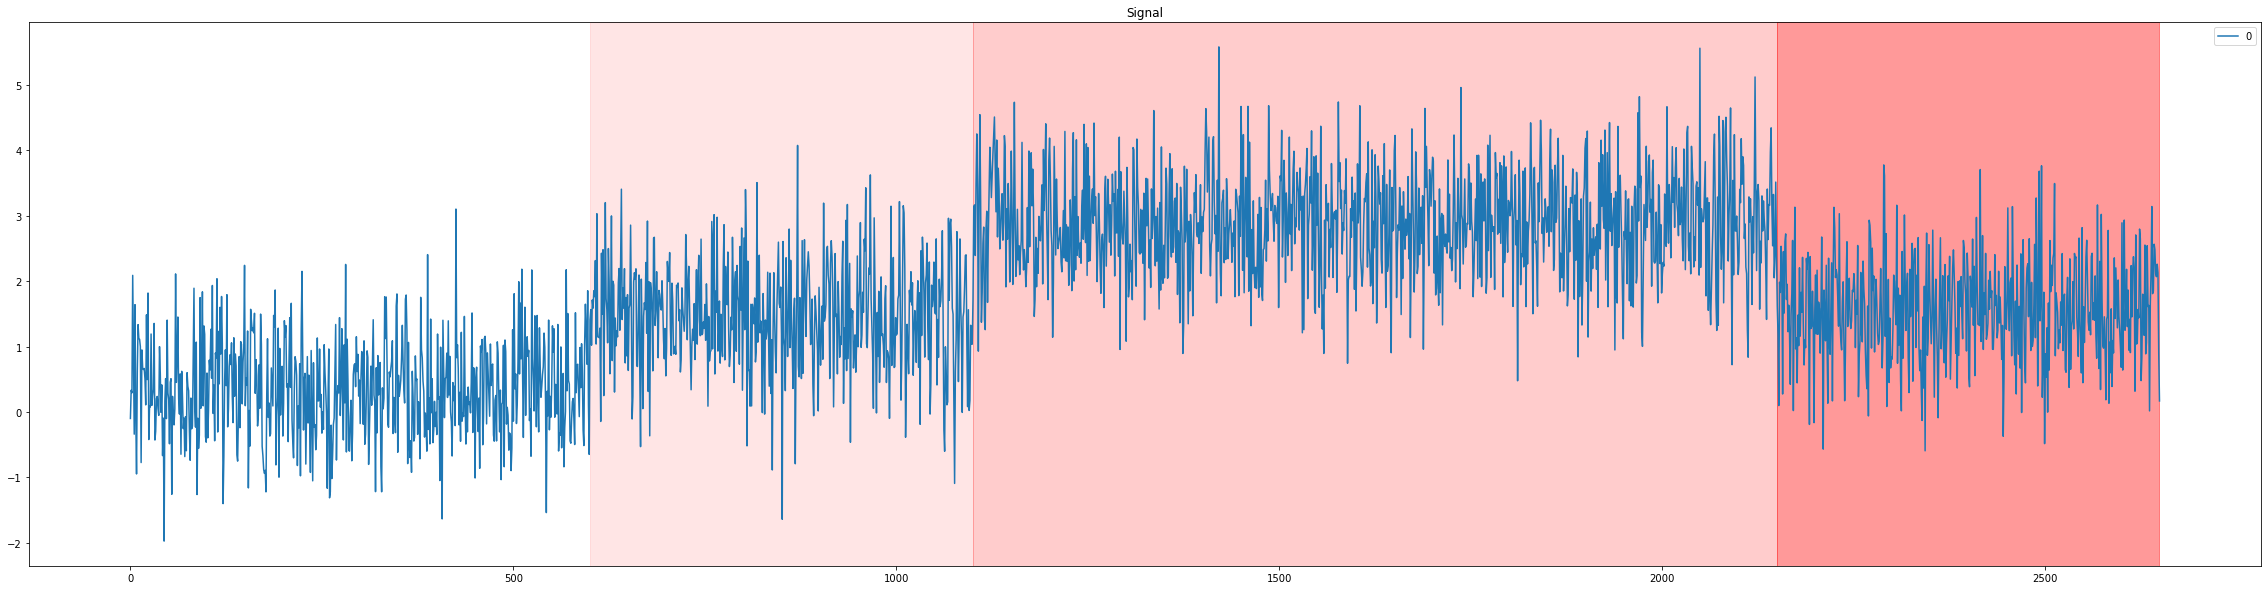

In [13]:
plot_total_df(
    data_df_synthetic, 
    "Signal", 
    changes=changes_gt_synthetic, 
    max_intensity=0.4
)

In [14]:
martingale_tester_synthetic = MartingaleTest(2, epsilon=0.96)
changes_pred_synthetic = run_martingale_tester(
    martingale_tester_synthetic,
    data_synthetic
)

In [15]:
metrics_in_range(gt=changes_gt_synthetic, pred=changes_pred_synthetic, interval=75)

{'precision': 0.75, 'recall': 1.0, 'F1': 0.8571428571428571}

In [16]:
changes_pred_synthetic

[629, 975, 1105, 2179]

## Cavitation dataset

Let us now try to run the approach on a real world dataset

In [17]:
path_prefix = "/home/alexpod/uni/magistrale_ai/secondo_anno/project_works/machine_learning/project/"  # data-raw path
train_path = os.path.join(path_prefix, "data-raw/DS1/")  # training files directory
test_path = os.path.join(path_prefix, "data-raw/DS2/")  # testing files directory

For efficiency reasons, we will assume that the dataset has already been prepared for us to load, thus the "Prepare data" section will be skipped.

In [18]:
LOAD_DATA = True

### Prepare data

In [19]:
if not LOAD_DATA:
    df_train = load_cavitation_data(train_path, {
        "OK": ["OK1", "OK2", "OK3", "OK4"],
        "IN": ["IN1"],
        "STANDING": ["STANDING1", "STANDING2"]
    }, verbose=1)

In [20]:
if not LOAD_DATA:
    print("There are {} samples in the dataframe".format(len(df_train)))

In [21]:
if not LOAD_DATA:
    df_train.head()

We can observe that the time field in our dataframe refers to a single sampling time unit.

In particular we have 75000 samples per time unit that we would like to squeeze down to a single value:

In [22]:
if not LOAD_DATA:
    statistical_features_train = get_cavitation_features(df_train)

In [23]:
if not LOAD_DATA:
    df_test = load_cavitation_data(test_path, {
        "OK": ["OK1"],
        "IN": ["IN1"],
        "STANDING": ["STANDING1", "STANDING2", "STANDING3", "STANDING4"]
    }, verbose=1)

    statistical_features_test = get_cavitation_features(df_test)

In [24]:
# To avoid recomputing features all over
import pickle

if LOAD_DATA:
    with open('data/cavitation/statistical_features_train.pkl', 'rb') as handle:
        statistical_features_train = pickle.load(handle)
        
    with open('data/cavitation/statistical_features_test.pkl', 'rb') as handle:
        statistical_features_test = pickle.load(handle)
        
"""
#with open('statistical_features_train.pkl', 'wb') as handle:
#    pickle.dump(statistical_features_train, handle)

#with open('statistical_features_train.pkl', 'rb') as handle:
#    unserialized_data = pickle.load(handle)

#with open('statistical_features_test.pkl', 'wb') as handle:
#    pickle.dump(statistical_features_test, handle)

#with open('statistical_features_test.pkl', 'rb') as handle:
#    unserialized_data = pickle.load(handle)
"""

"\n#with open('statistical_features_train.pkl', 'wb') as handle:\n#    pickle.dump(statistical_features_train, handle)\n\n#with open('statistical_features_train.pkl', 'rb') as handle:\n#    unserialized_data = pickle.load(handle)\n\n#with open('statistical_features_test.pkl', 'wb') as handle:\n#    pickle.dump(statistical_features_test, handle)\n\n#with open('statistical_features_test.pkl', 'rb') as handle:\n#    unserialized_data = pickle.load(handle)\n"

We've extracted four types of statistical features (single value from 75000 samples) per time unit: mean, std, skewness, kurtosis

In [25]:
statistical_features_train["mean"]

,P1_x,P1_y,P1_z,P2_x,P2_y,P2_z,stream_idx,status
time,,,,,,,,
2013-01-10 08:28:35.281,-0.018477,-0.007019,0.001150,0.046848,0.031780,0.050179,0,0
2013-01-10 08:28:38.281,-0.018573,-0.007016,0.000854,0.046712,0.031624,0.049469,0,0
2013-01-10 08:28:41.281,-0.018778,-0.007387,0.004449,0.046011,0.031195,0.047970,0,0
2013-01-10 08:28:44.281,-0.018884,-0.007908,0.004151,0.045750,0.031047,0.046726,0,0
2013-01-10 08:28:47.281,-0.019134,-0.008219,0.003734,0.045211,0.030805,0.045695,0,0
...,...,...,...,...,...,...,...,...
2013-01-10 09:24:44.437,-0.041707,-0.040574,-0.024623,0.018112,0.005666,-0.002580,6,2
2013-01-10 09:24:47.437,-0.041545,-0.040016,-0.025320,0.017877,0.005230,-0.002479,6,2
2013-01-10 09:24:50.437,-0.041861,-0.040351,-0.024094,0.017869,0.005464,-0.002547,6,2


We went from 77775000 samples to 1037, which are easier to manage

### Data visualization

Let us now visualize the series:

In [26]:
status = statistical_features_train["mean"]["stream_idx"]
# get indices of timeseries where there's a change of status
changes_gt = np.where(np.roll(status, 1)!=status)[0][1:]

In [27]:
visualize_columns = ["P1_x", "P1_y", "P1_z", "P2_x", "P2_y", "P2_z"]

Changes in stream distribution occurred at:
	2013-01-10 08:29:08.281000
	2013-01-10 08:33:53.296000
	2013-01-10 08:44:53.328000
	2013-01-10 08:47:53.343000
	2013-01-10 08:51:26.343000
	2013-01-10 09:03:20.375000


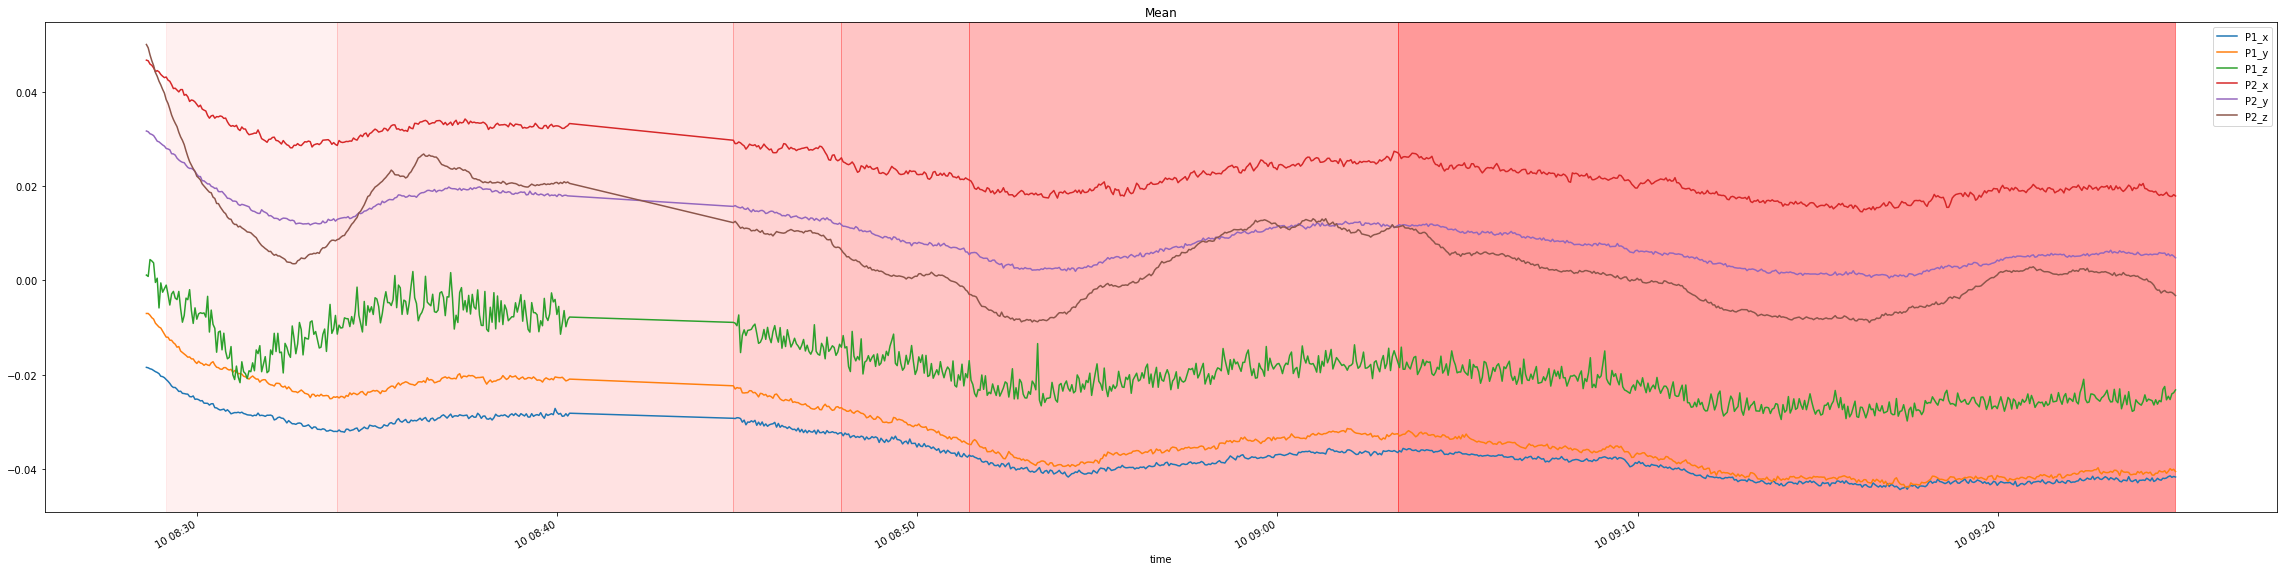

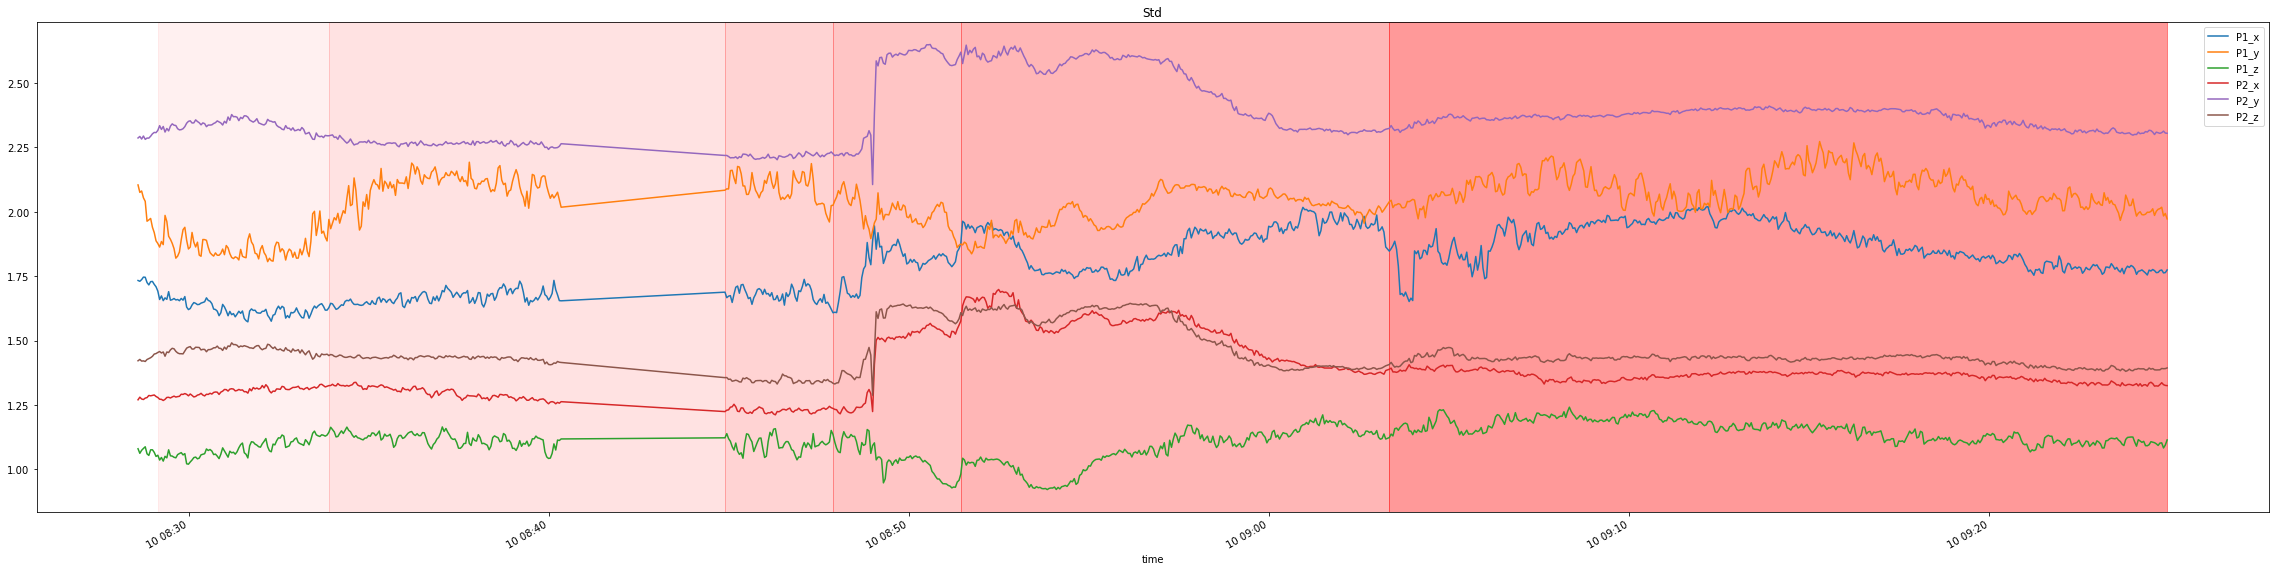

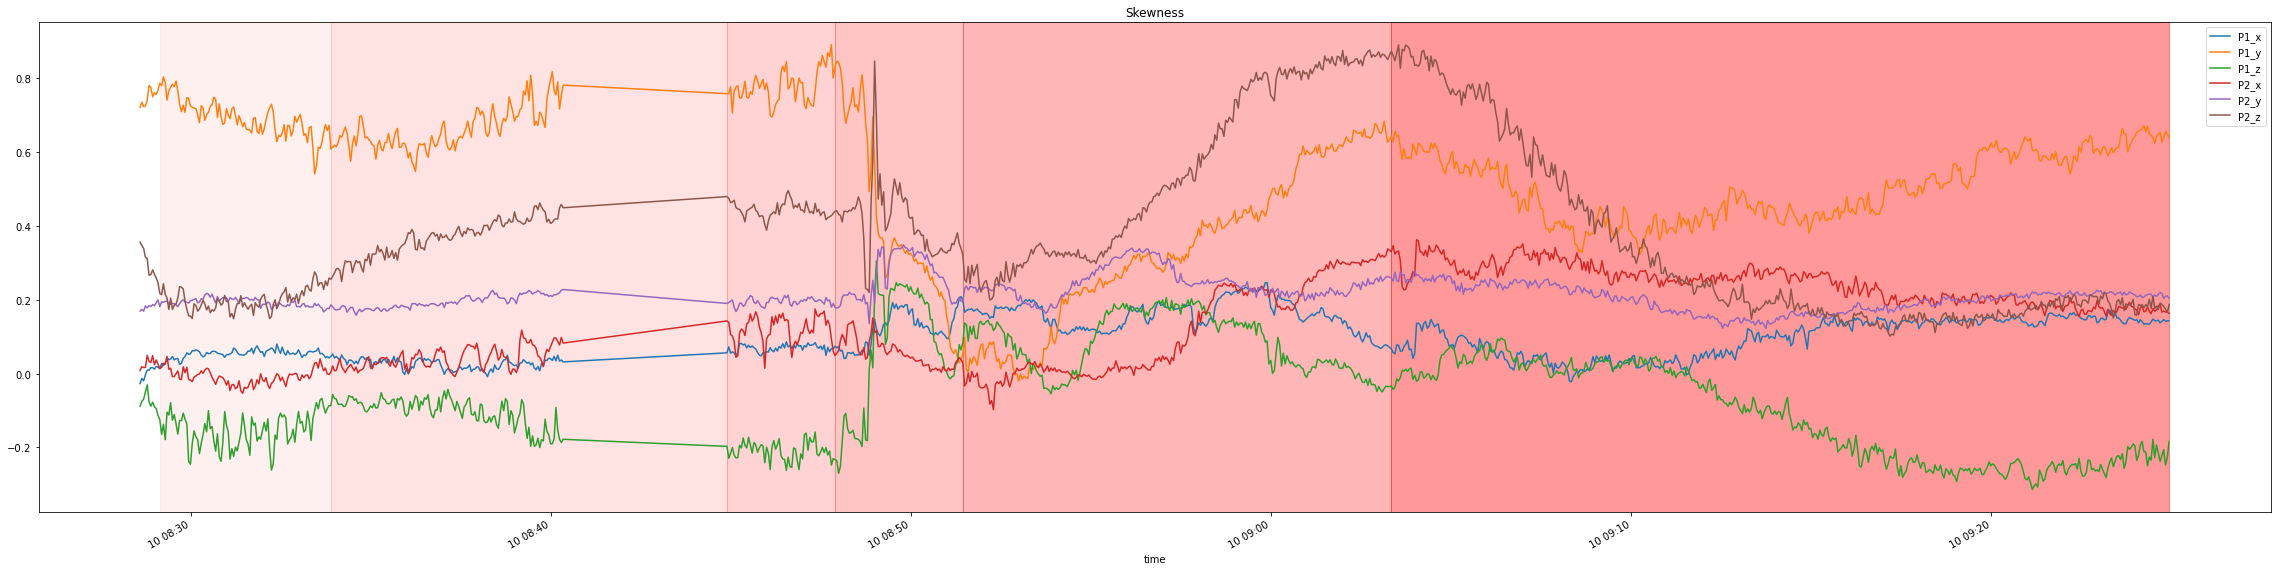

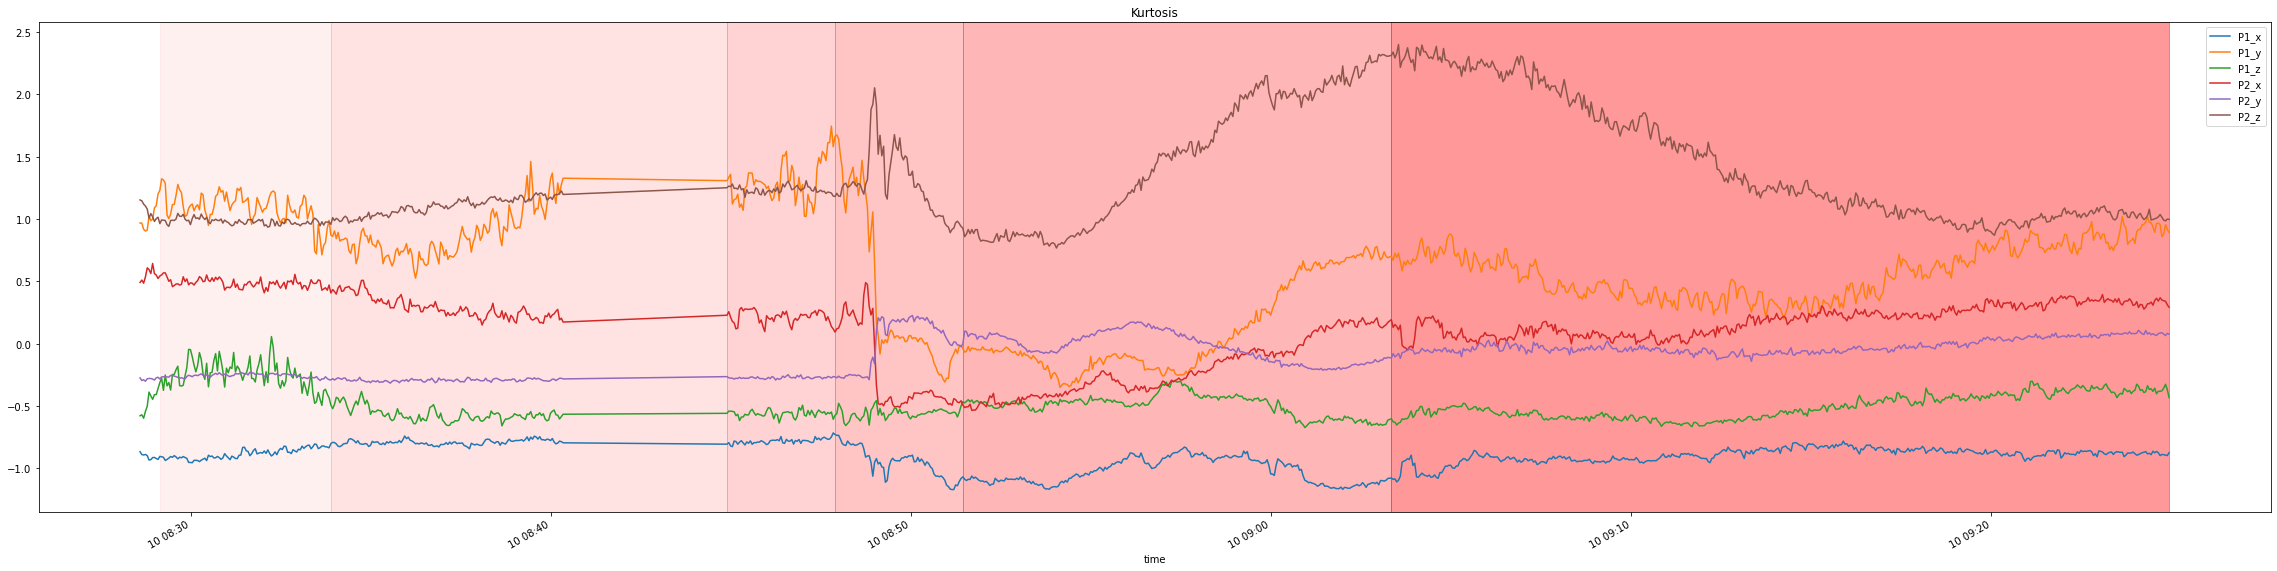

In [28]:
plot_total_df(
    statistical_features_train["mean"][visualize_columns], 
    "Mean", 
    changes=changes_gt, 
    max_intensity=0.4
)

plot_total_df(
    statistical_features_train["std"][visualize_columns], 
    "Std", 
    changes=changes_gt, 
    max_intensity=0.4,
    print_changes=False
)

plot_total_df(
    statistical_features_train["skewness"][visualize_columns], 
    "Skewness", 
    changes=changes_gt, 
    max_intensity=0.4,
    print_changes=False
)

plot_total_df(
    statistical_features_train["kurtosis"][visualize_columns], 
    "Kurtosis", 
    changes=changes_gt, 
    max_intensity=0.4,
    print_changes=False
)

We can see something different going on in highlighted zones, however we are viewing 6 series at same time.

Let us visualize an averaged signal to see if we still preserve the trend.

In [29]:
statistical_features_averaged_train = {k: average_signal_columns(df) for (k, df) in statistical_features_train.items()}

Changes in stream distribution occurred at:
	2013-01-10 08:29:08.281000
	2013-01-10 08:33:53.296000
	2013-01-10 08:44:53.328000
	2013-01-10 08:47:53.343000
	2013-01-10 08:51:26.343000
	2013-01-10 09:03:20.375000


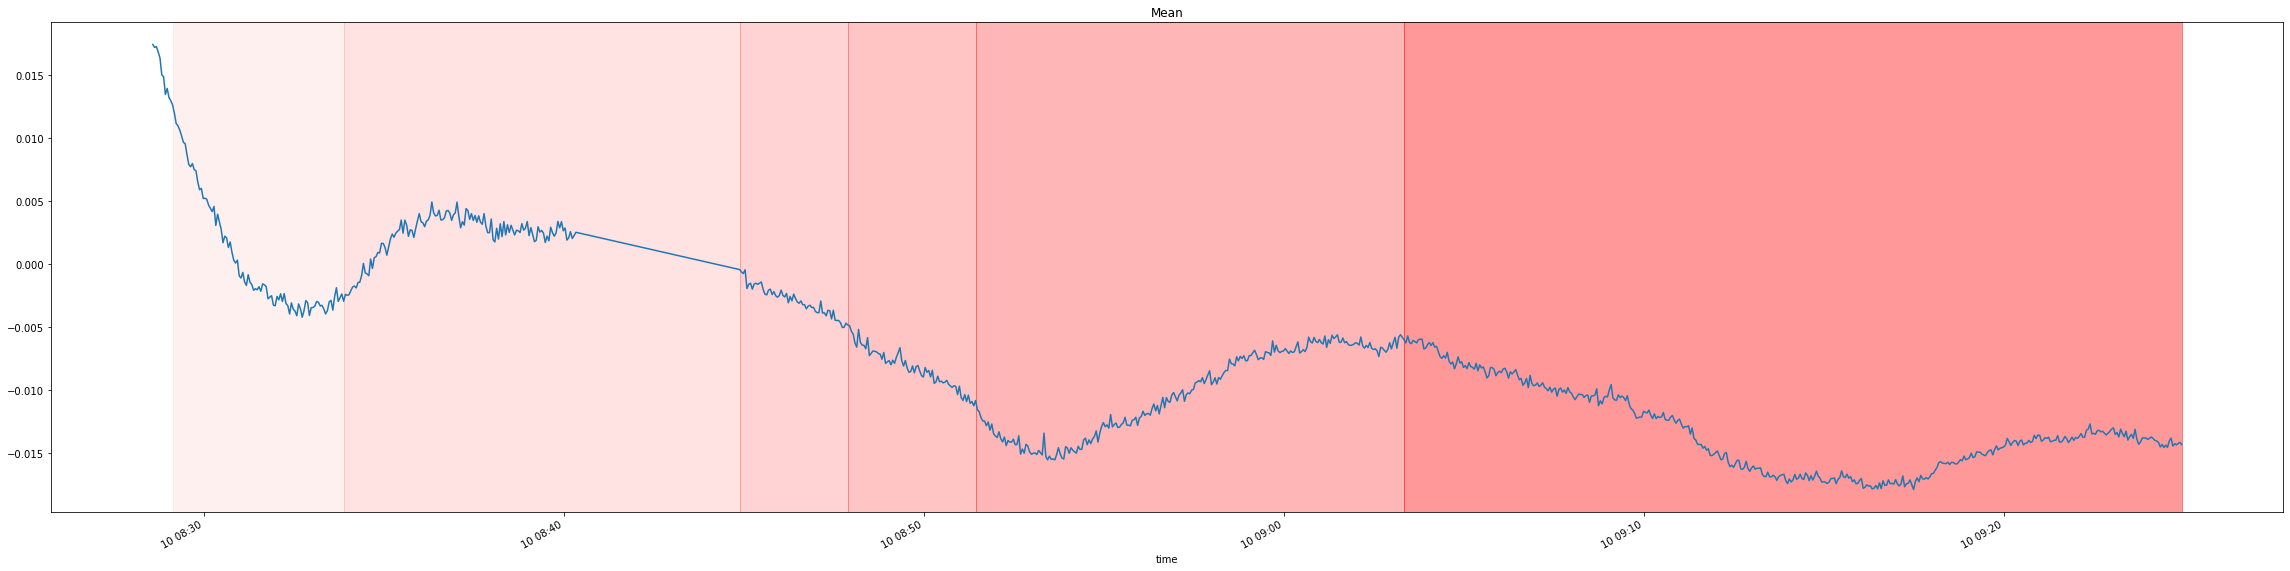

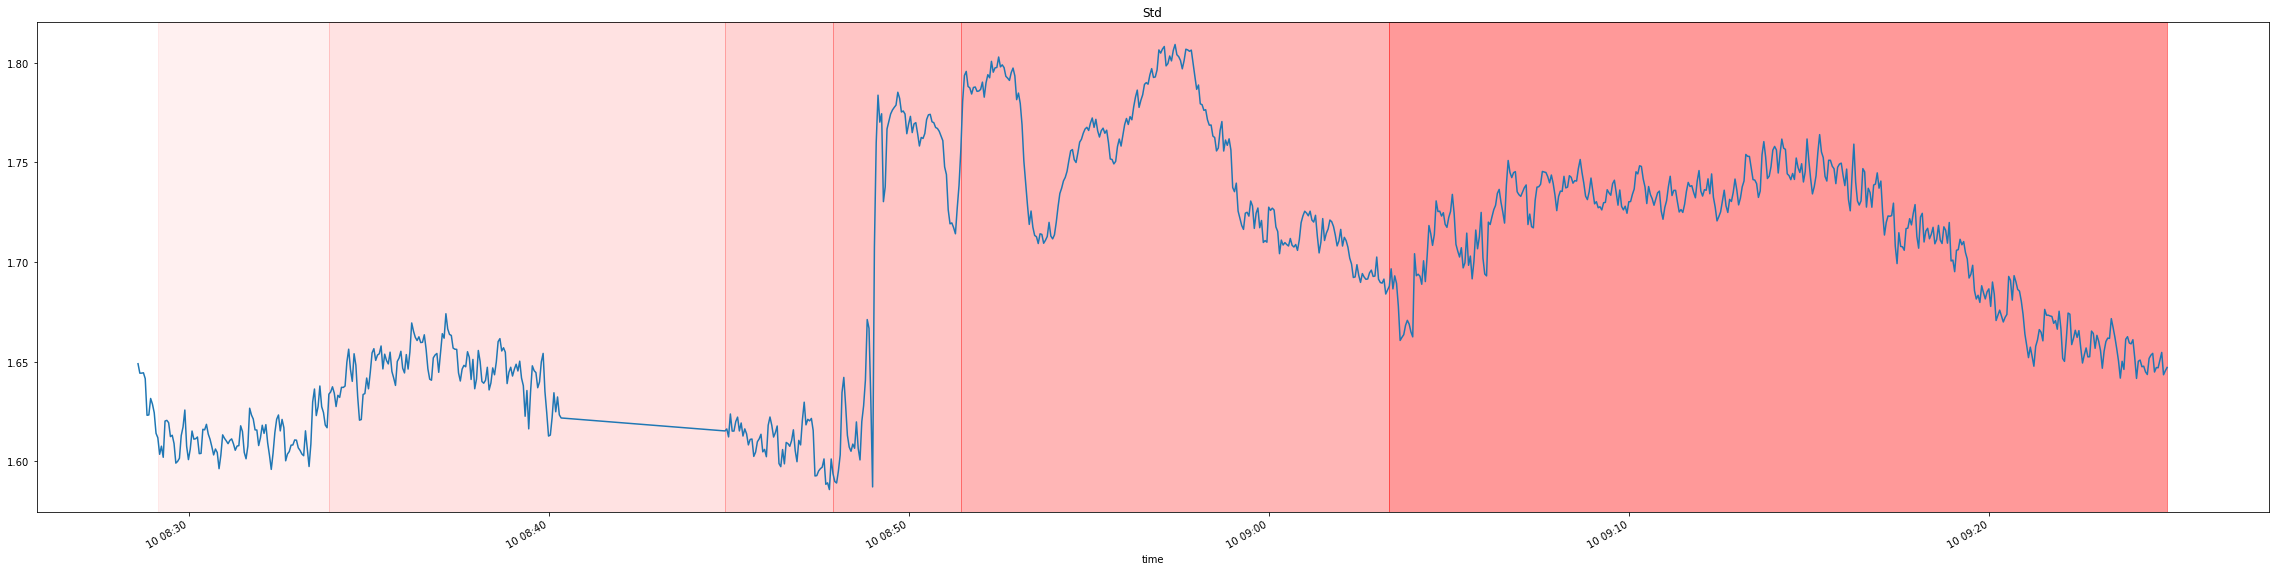

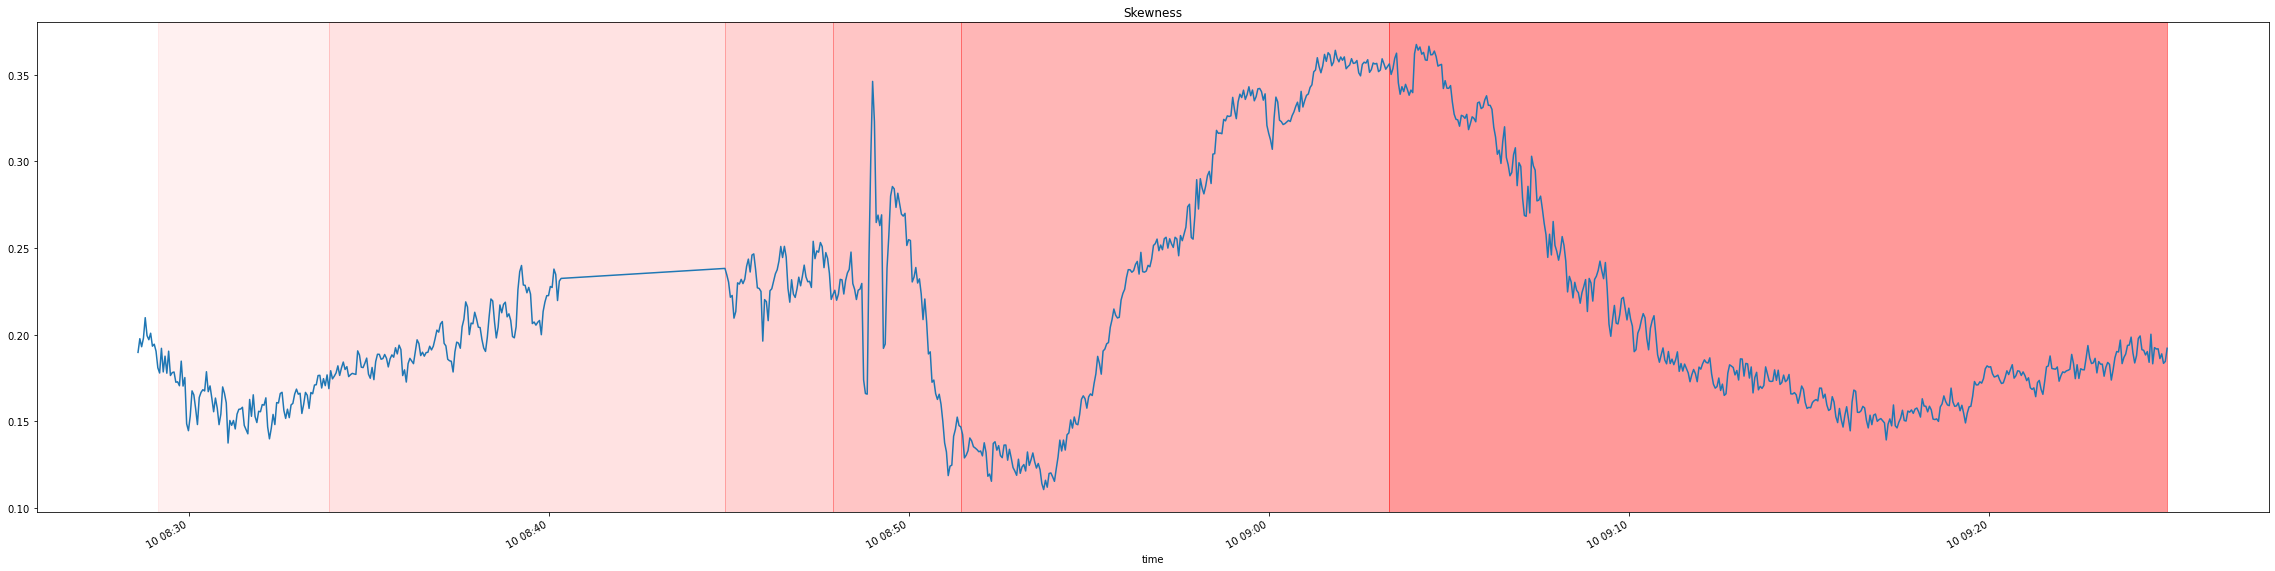

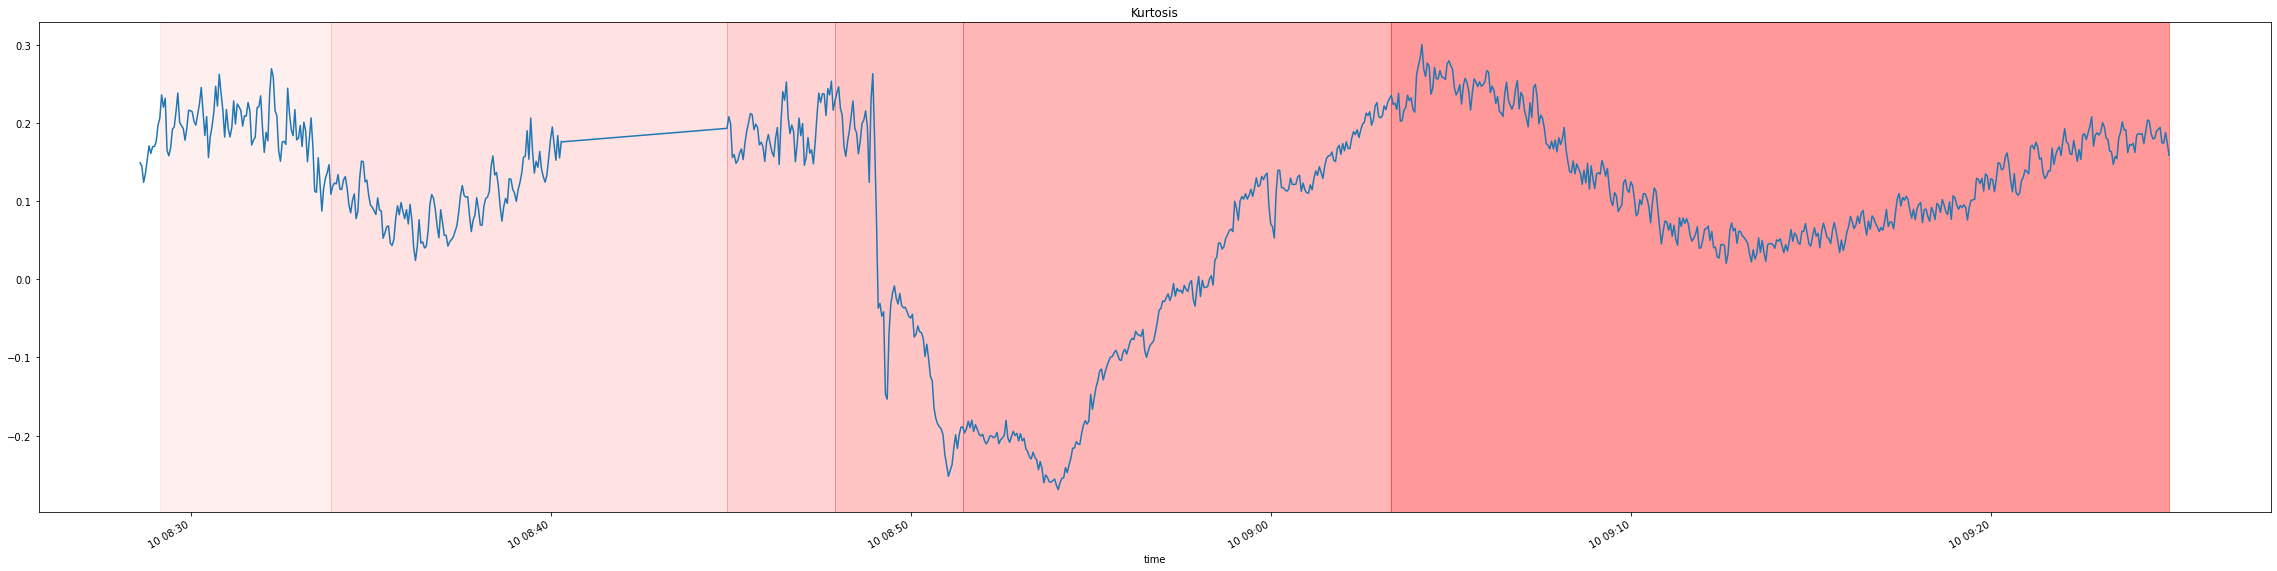

In [30]:
plot_total_df(
    statistical_features_averaged_train["mean"]["average_column"], 
    "Mean", 
    changes=changes_gt, 
    max_intensity=0.4
)

plot_total_df(
    statistical_features_averaged_train["std"]["average_column"], 
    "Std", 
    changes=changes_gt, 
    max_intensity=0.4,
    print_changes=False
)

plot_total_df(
    statistical_features_averaged_train["skewness"]["average_column"], 
    "Skewness", 
    changes=changes_gt, 
    max_intensity=0.4,
    print_changes=False
)

plot_total_df(
    statistical_features_averaged_train["kurtosis"]["average_column"], 
    "Kurtosis", 
    changes=changes_gt, 
    max_intensity=0.4,
    print_changes=False
)

### Distribution drift detection

In [63]:
martingale_tester = MartingaleTest(10, epsilon=0.82)

In [64]:
# TODO: fix N-dimensional case martingale tester (p-value calculation has problems now)
changes_pred = run_martingale_tester(
    martingale_tester,
    statistical_features_averaged_train["kurtosis"]["average_column"]
)

In [65]:
metrics_in_range(gt=changes_gt, pred=changes_pred, interval=75)

{'precision': 0.5625, 'recall': 1.0, 'F1': 0.72}

In [66]:
print(changes_pred)

[107, 138, 214, 299, 327, 349, 446, 479, 510, 543, 577, 604, 696, 749, 930, 979]


In [58]:
# grid search
epsilon = [0.80, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98]
M = [4, 8, 10, 20]
interval = 40
best_params = {"metric": 0.0, "params": None}
for e in epsilon:
    for m in M:
        martingale_tester = MartingaleTest(m, epsilon=e)
        changes_pred = run_martingale_tester(
            martingale_tester,
            statistical_features_averaged_train["kurtosis"]["average_column"]
        )
        metrics = metrics_in_range(gt=changes_gt, pred=changes_pred, interval=interval)
        if metrics["F1"] > best_params["metric"]:
            best_params["metric"] = metrics["F1"]
            best_params["params"] = (e, m)
        print("e={}, m={}, F1={}".format(e, m, metrics["F1"]))

e=0.8, m=4, F1=0.5882352941176471
e=0.8, m=8, F1=0.5925925925925926
e=0.8, m=10, F1=0.6153846153846153
e=0.8, m=20, F1=0.6363636363636364
e=0.81, m=4, F1=0.5882352941176471
e=0.81, m=8, F1=0.6206896551724138
e=0.81, m=10, F1=0.6153846153846153
e=0.81, m=20, F1=0.6363636363636364
e=0.82, m=4, F1=0.5882352941176471
e=0.82, m=8, F1=0.5925925925925926
e=0.82, m=10, F1=0.6666666666666666
e=0.82, m=20, F1=0.6
e=0.83, m=4, F1=0.5882352941176471
e=0.83, m=8, F1=0.5833333333333334
e=0.83, m=10, F1=0.5833333333333334
e=0.83, m=20, F1=0.6666666666666666
e=0.84, m=4, F1=0.6060606060606061
e=0.84, m=8, F1=0.5833333333333334
e=0.84, m=10, F1=0.6363636363636364
e=0.84, m=20, F1=0.6363636363636364
e=0.85, m=4, F1=0.625
e=0.85, m=8, F1=0.5833333333333334
e=0.85, m=10, F1=0.6399999999999999
e=0.85, m=20, F1=0.6086956521739131
e=0.86, m=4, F1=0.5806451612903226
e=0.86, m=8, F1=0.6363636363636364
e=0.86, m=10, F1=0.6363636363636364
e=0.86, m=20, F1=0.6
e=0.87, m=4, F1=0.6
e=0.87, m=8, F1=0.636363636363636

In [59]:
best_params

{'metric': 0.6666666666666666, 'params': (0.82, 10)}

Changes in stream distribution occurred at:
	2013-01-10 08:33:56.296000
	2013-01-10 08:35:29.296000
	2013-01-10 08:39:17.312000
	2013-01-10 08:48:02.343000
	2013-01-10 08:49:26.343000
	2013-01-10 08:50:32.343000
	2013-01-10 08:55:23.359000
	2013-01-10 08:57:02.359000
	2013-01-10 08:58:35.359000
	2013-01-10 09:00:14.375000
	2013-01-10 09:01:56.375000
	2013-01-10 09:03:20.375000
	2013-01-10 09:07:56.390000
	2013-01-10 09:10:35.406000
	2013-01-10 09:19:38.421000
	2013-01-10 09:22:05.437000


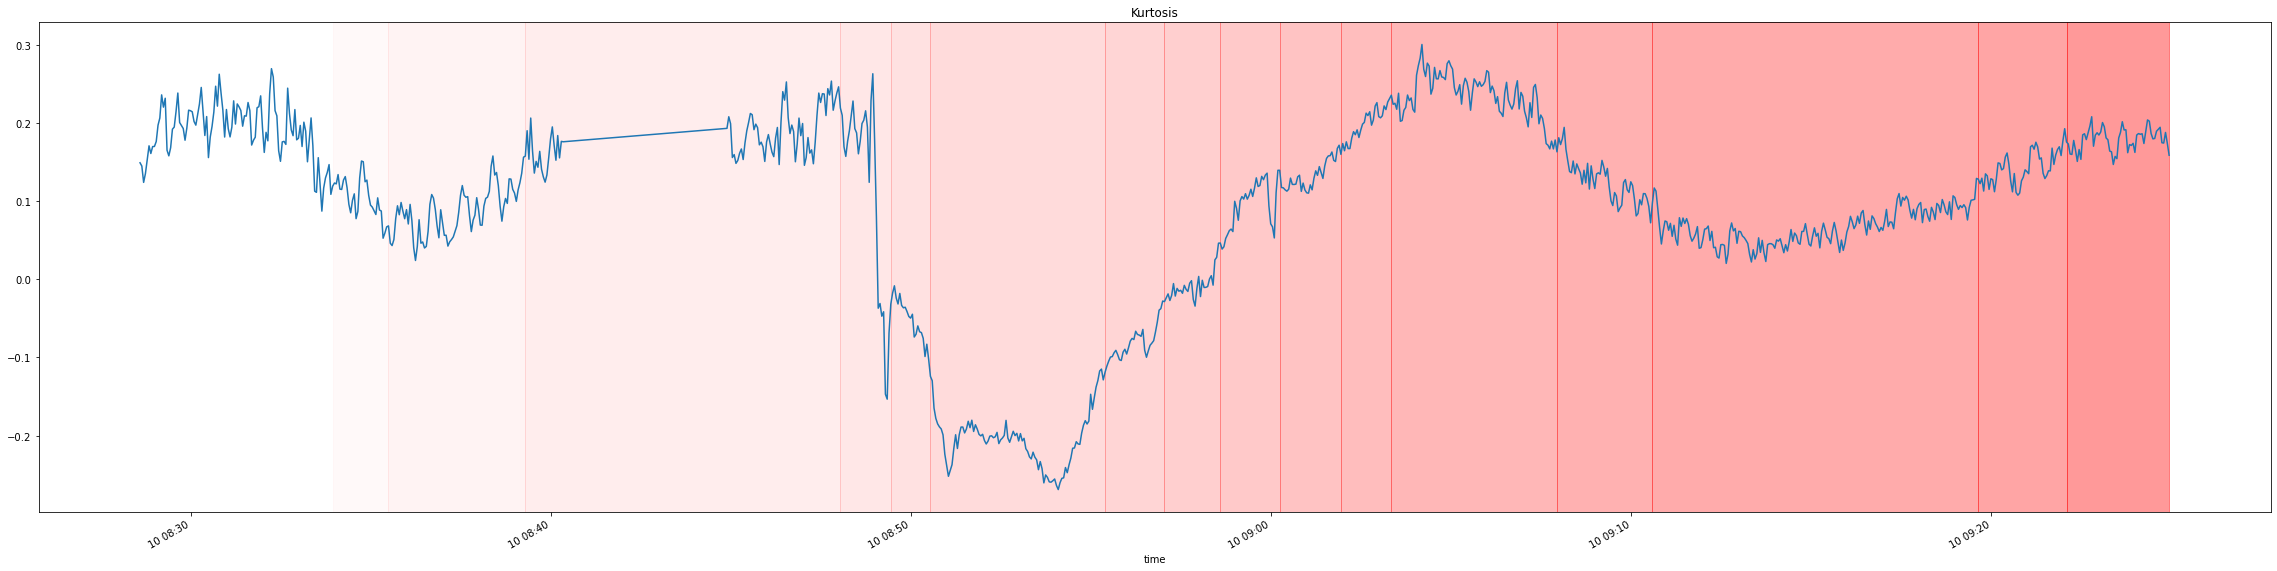

Changes in stream distribution occurred at:
	2013-01-10 08:29:08.281000
	2013-01-10 08:33:53.296000
	2013-01-10 08:44:53.328000
	2013-01-10 08:47:53.343000
	2013-01-10 08:51:26.343000
	2013-01-10 09:03:20.375000


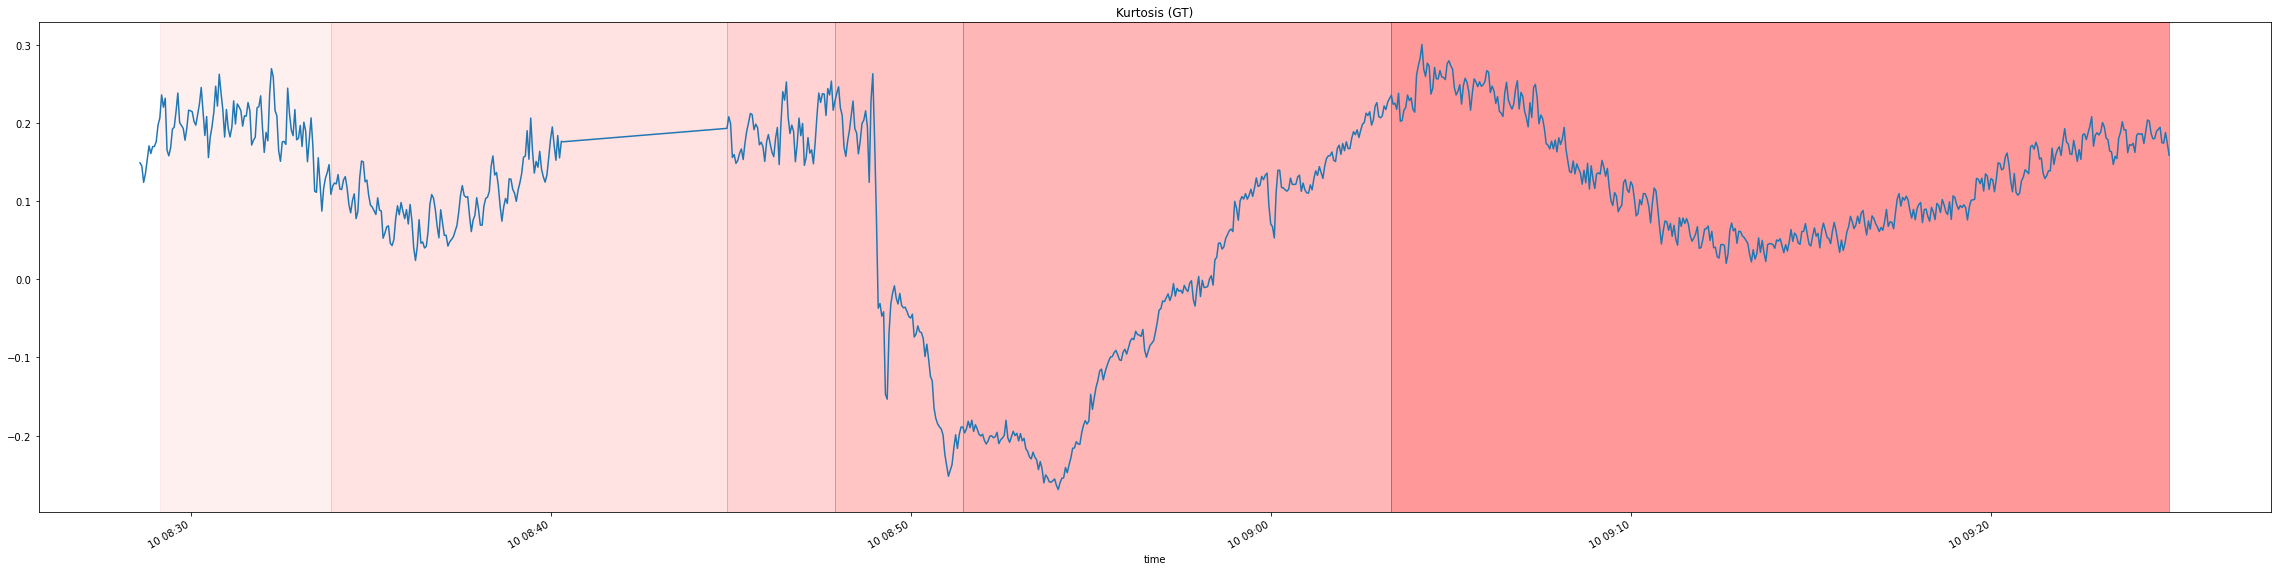

In [67]:
plot_total_df(
    statistical_features_averaged_train["kurtosis"]["average_column"], 
    "Kurtosis", 
    changes=changes_pred, 
    max_intensity=0.4
)

plot_total_df(
    statistical_features_averaged_train["kurtosis"]["average_column"], 
    "Kurtosis (GT)", 
    changes=changes_gt, 
    max_intensity=0.4
)

In [69]:
import matplotlib.pyplot as plt

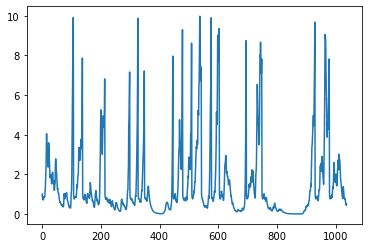

In [70]:
plt.plot(martingale_tester.M)

In [93]:
statistical_features_train["kurtosis"][visualize_columns].to_numpy()

array([[-0.8659123 ,  0.96880626, -0.57810437,  0.49176948, -0.27402537,
         1.15390892],
       [-0.88930541,  0.96791063, -0.56992459,  0.51098214, -0.29532747,
         1.14693036],
       [-0.89261435,  0.91857845, -0.59771266,  0.48585558, -0.28887189,
         1.12050173],
       ...,
       [-0.89301232,  0.9552684 , -0.3255897 ,  0.34109341,  0.06553776,
         0.98613347],
       [-0.8972865 ,  0.91569522, -0.36873816,  0.31275705,  0.0830616 ,
         1.00025997],
       [-0.87354222,  0.89303873, -0.4322724 ,  0.29215693,  0.07669137,
         0.99810049]])

In [99]:
martingale_tester_nd = MartingaleTestND(4, epsilon=0.96)

In [100]:
changes_pred_nd, _ = run_martingale_tester_nd(
    martingale_tester_nd,
    statistical_features_train["std"][visualize_columns]
)

Changes in stream distribution occurred at:
	2013-01-10 08:36:05.312000
	2013-01-10 08:44:59.328000
	2013-01-10 08:49:44.343000
	2013-01-10 08:58:11.375000
	2013-01-10 09:01:08.375000
	2013-01-10 09:04:56.390000
	2013-01-10 09:16:17.421000
	2013-01-10 09:22:41.437000


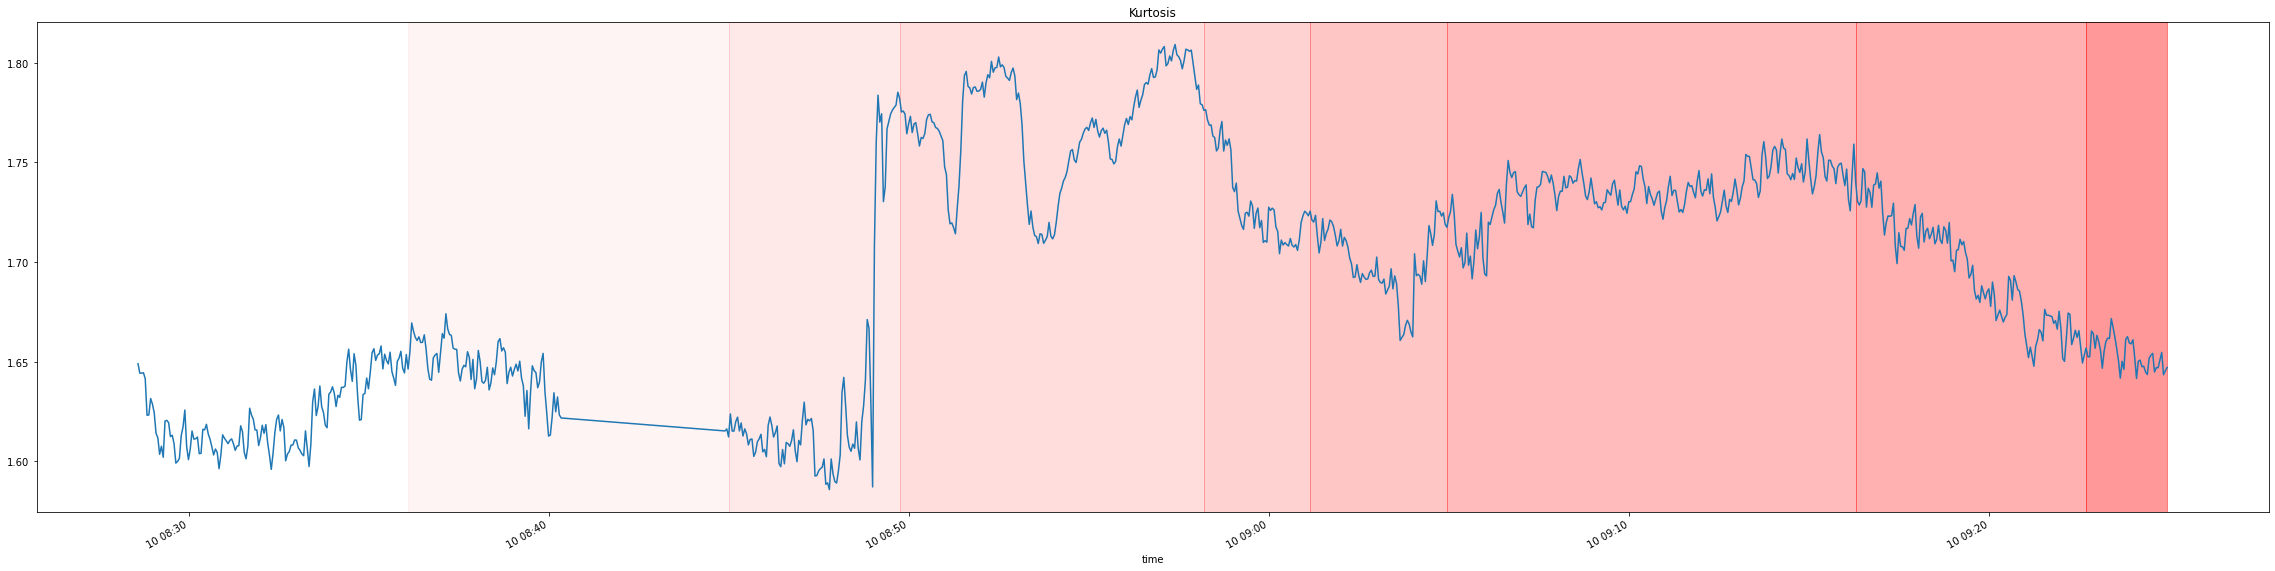

In [101]:
plot_total_df(
    statistical_features_averaged_train["std"]["average_column"], 
    "Kurtosis", 
    changes=changes_pred_nd, 
    max_intensity=0.4
)

In [102]:
metrics_in_range(gt=changes_gt, pred=changes_pred_nd, interval=30)

{'precision': 0.125, 'recall': 0.16666666666666666, 'F1': 0.14285714285714288}

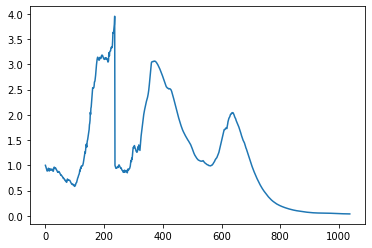

In [133]:
plt.plot(martingale_tester_nd.M)